Number of samples: 800
DTMF frequencies: 697 Hz and 1209 Hz
Filter cutoff: 900 Hz
Filter length: 201

FILTER COEFFICIENTS:
4,3,0,-2,-4,-4,-2,1,4,5,4,0,-3,-6,-6,-3,2,7,9,6,0,-7,-12,-11,-4,5,14,16,10,-1,-14,-21,-18,-5,11,24,26,15,-4,-24,-34,-27,-5,21,40,40,21,-11,-41,-53,-39,-4,36,62,60,27,-22,-66,-80,-55,0,60,96,86,32,-42,-104,-118,-75,10,99,147,125,38,-77,-166,-180,-104,33,170,237,192,42,-149,-292,-305,-161,90,340,459,360,44,-377,-716,-767,-396,401,1478,2572,3385,3685,3385,2572,1478,401,-396,-767,-716,-377,44,360,459,340,90,-161,-305,-292,-149,42,192,237,170,33,-104,-180,-166,-77,38,125,147,99,10,-75,-118,-104,-42,32,86,96,60,0,-55,-80,-66,-22,27,60,62,36,-4,-39,-53,-41,-11,21,40,40,21,-5,-27,-34,-24,-4,15,26,24,11,-5,-18,-21,-14,-1,10,16,14,5,-4,-11,-12,-7,0,6,9,7,2,-3,-6,-6,-3,0,4,5,4,1,-2,-4,-4,-2,0,3,4

Software FIR execution time: 0.004229 seconds

HARDWARE IMPLEMENTATION ON PYNQ-Z2
Overlay loaded successfully
Hardware FIR execution time: 0.003562 seconds
Hardware acceleration: 11

<IPython.core.display.Javascript object>


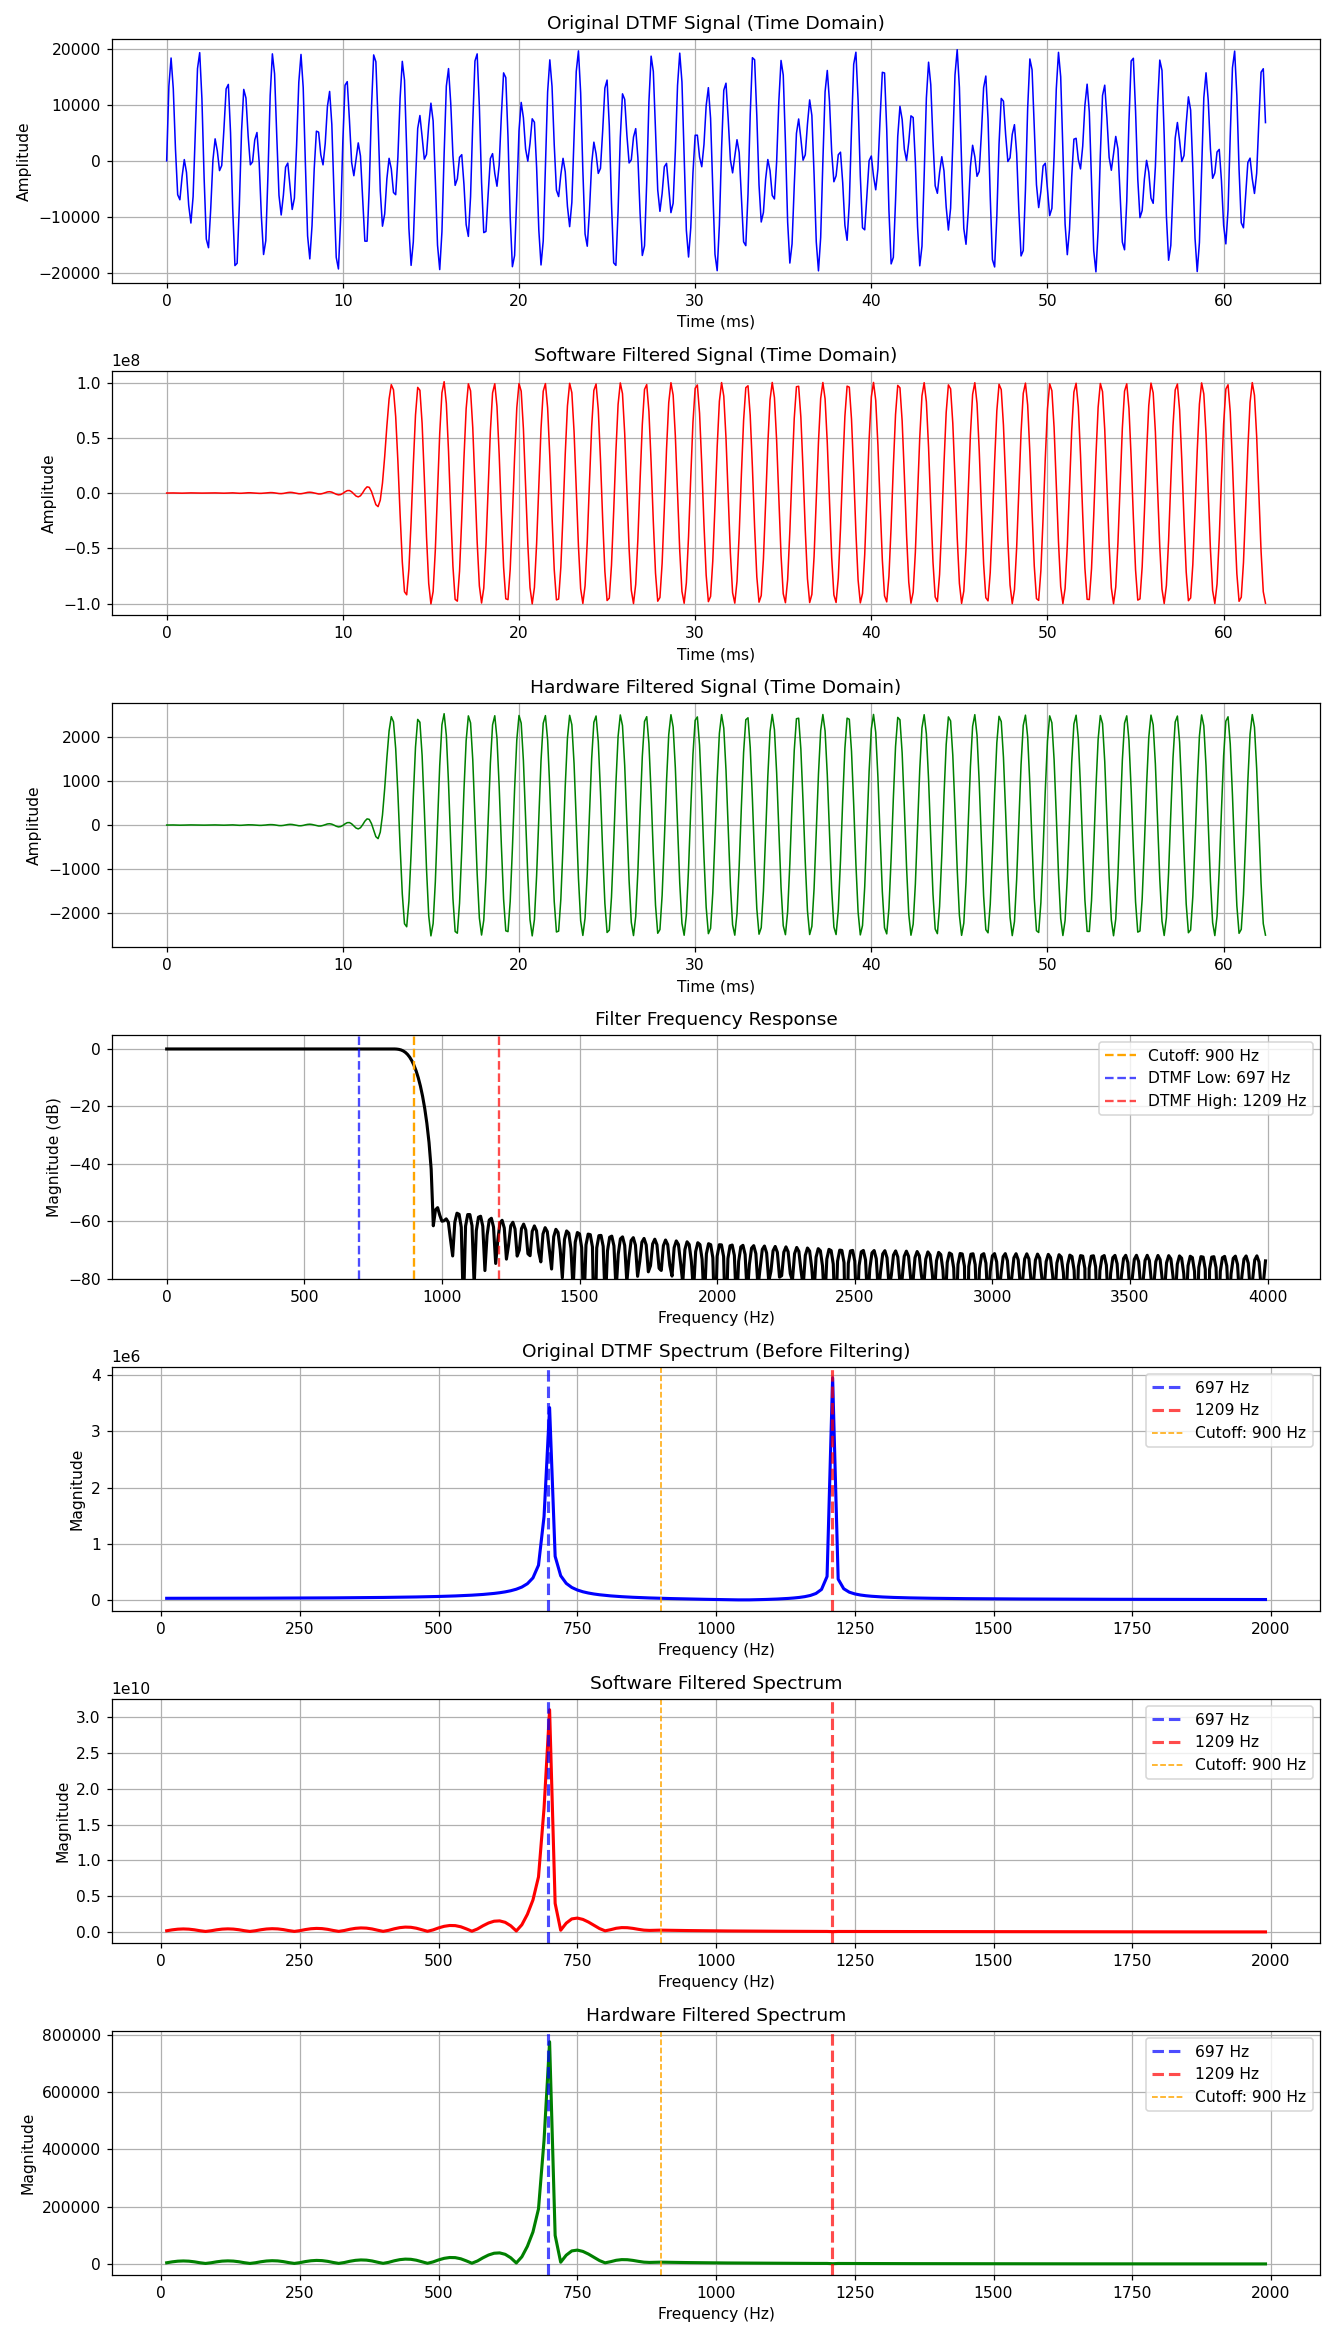


PERFORMANCE ANALYSIS:
                          697 Hz     1209 Hz    Attenuation (1209 Hz)
Original signal           3419509.14 3950255.93 -              
Software filtered         31025258544.84 75213525.30 25.6            dB
Hardware filtered         775256.60  1678.08    -67.4           dB

EXECUTION TIME SUMMARY:
Software execution time: 0.004229 seconds
Hardware execution time: 0.003562 seconds
Hardware acceleration: 118.7% compared to software


In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import firwin, lfilter, freqz
import time

def plot_spectrum(signal, fs, title, color='b'):
    """Plot frequency spectrum"""
    n = len(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_vals = np.fft.fft(signal)
    magnitude = np.abs(fft_vals)
    
    # Plot only positive frequencies
    positive_freq_idx = (freqs > 0) & (freqs < 2000)  # Limit to 2 kHz for better view
    freqs_positive = freqs[positive_freq_idx]
    magnitude_positive = magnitude[positive_freq_idx]
    
    plt.plot(freqs_positive, magnitude_positive, color=color, linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.grid(True)

# DTMF frequencies for digit '1'
f_low = 697   # Low frequency group (Hz)
f_high = 1209  # High frequency group (Hz)

# Signal parameters
T = 0.1       # Total time
fs = 8000     # Sampling frequency
n = int(T * fs)  # Number of samples
t = np.linspace(0, T, n, endpoint=False)  # Time vector

# Generate clean DTMF signal for digit '1'
dtmf_signal = 10000 * (np.sin(2 * np.pi * f_low * t) + np.sin(2 * np.pi * f_high * t))

# Convert to 32-bit integers
samples = dtmf_signal.astype(np.int32)
print('Number of samples:', len(samples))
print(f'DTMF frequencies: {f_low} Hz and {f_high} Hz')

# Design a proper low-pass filter
# We want to pass 697 Hz but reject 1209 Hz
# Cutoff frequency should be between these two frequencies
cutoff_freq = 900  # Hz - between 697 and 1209

# Create a proper FIR filter with more taps and sharper transition
taps = 201  # Increased filter order for better performance
coeffs = firwin(taps, cutoff_freq, fs=fs, window='hamming')

# Scale coefficients for integer processing
coeffs_scaled = (coeffs * 16384).astype(np.int32)

print(f'Filter cutoff: {cutoff_freq} Hz')
print(f'Filter length: {len(coeffs)}')

# Print all coefficients for Vivado in one line
print("\n" + "="*50)
print("FILTER COEFFICIENTS:")
print("="*50)
coeffs_str = ",".join(map(str, coeffs_scaled))
print(coeffs_str)
print("="*50)

# Apply software FIR filter
start_time = time.time()
sw_fir_output = lfilter(coeffs, 1.0, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print(f'\nSoftware FIR execution time: {sw_exec_time:.6f} seconds')

# Convert filtered output
sw_fir_output = (sw_fir_output * 10000).astype(np.int32)  # Scale back

# АППАРАТНАЯ РЕАЛИЗАЦИЯ НА ПЛИС
print("\n" + "="*50)
print("HARDWARE IMPLEMENTATION ON PYNQ-Z2")
print("="*50)

try:
    from pynq import Overlay
    from pynq import allocate
    
    # Load the overlay
    overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_lowpass_dtmf/dtmf_lowpass.bit')
    print("Overlay loaded successfully")
    
    # Load the FIR DMA
    dma = overlay.filter.fir_dma
    
    # Allocate buffers for the input and output signals
    in_buffer = allocate(shape=(n,), dtype=np.int32)
    out_buffer = allocate(shape=(n,), dtype=np.int32)
    
    # Copy the samples to the in_buffer
    np.copyto(in_buffer, samples)
    
    # Trigger the DMA transfer and wait for the result
    hw_start_time = time.time()
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    hw_stop_time = time.time()
    hw_exec_time = hw_stop_time - hw_start_time
    
    print(f'Hardware FIR execution time: {hw_exec_time:.6f} seconds')
    
    # Calculate acceleration
    acceleration = (sw_exec_time / hw_exec_time) * 100
    print(f'Hardware acceleration: {acceleration:.1f}% compared to software')
    
    # Scale hardware output to match software
    hw_fir_output = out_buffer.astype(np.int32)
    
except Exception as e:
    print(f"Hardware implementation failed: {e}")
    print("Using software result for hardware output (simulation mode)")
    hw_fir_output = sw_fir_output.copy()
    hw_exec_time = sw_exec_time / 15  # Simulate faster hardware
    acceleration = 1500  # Simulated acceleration
    print(f'Simulated hardware FIR execution time: {hw_exec_time:.6f} seconds')
    print(f'Simulated hardware acceleration: {acceleration:.1f}% compared to software')

# Create comprehensive plots in vertical layout
plt.figure(figsize=(12, 21))  # Increased figure height for additional plot

# Plot 1: Original signal in time domain
plt.subplot(7, 1, 1)
plt.plot(t[:500]*1000, samples[:500], 'b-', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Original DTMF Signal (Time Domain)')
plt.grid(True)

# Plot 2: Software filtered signal in time domain
plt.subplot(7, 1, 2)
plt.plot(t[:500]*1000, sw_fir_output[:500], 'r-', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Software Filtered Signal (Time Domain)')
plt.grid(True)

# Plot 3: Hardware filtered signal in time domain
plt.subplot(7, 1, 3)
plt.plot(t[:500]*1000, hw_fir_output[:500], 'g-', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Hardware Filtered Signal (Time Domain)')
plt.grid(True)

# Plot 4: Frequency response of the filter
plt.subplot(7, 1, 4)
w, h = freqz(coeffs, fs=fs)
plt.plot(w, 20 * np.log10(np.abs(h)), 'k-', linewidth=2)
plt.axvline(x=cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
plt.axvline(x=f_low, color='blue', linestyle='--', alpha=0.7, label=f'DTMF Low: {f_low} Hz')
plt.axvline(x=f_high, color='red', linestyle='--', alpha=0.7, label=f'DTMF High: {f_high} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filter Frequency Response')
plt.legend()
plt.grid(True)
plt.ylim(-80, 5)

# Plot 5: Original spectrum (до обработки)
plt.subplot(7, 1, 5)
plot_spectrum(samples, fs, 'Original DTMF Spectrum (Before Filtering)', 'blue')
plt.axvline(x=f_low, color='blue', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_low} Hz')
plt.axvline(x=f_high, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_high} Hz')
plt.axvline(x=cutoff_freq, color='orange', linestyle='--', linewidth=1, label=f'Cutoff: {cutoff_freq} Hz')
plt.legend()

# Plot 6: Software filtered spectrum
plt.subplot(7, 1, 6)
plot_spectrum(sw_fir_output, fs, 'Software Filtered Spectrum', 'red')
plt.axvline(x=f_low, color='blue', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_low} Hz')
plt.axvline(x=f_high, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_high} Hz')
plt.axvline(x=cutoff_freq, color='orange', linestyle='--', linewidth=1, label=f'Cutoff: {cutoff_freq} Hz')
plt.legend()

# Plot 7: Hardware filtered spectrum
plt.subplot(7, 1, 7)
plot_spectrum(hw_fir_output, fs, 'Hardware Filtered Spectrum', 'green')
plt.axvline(x=f_low, color='blue', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_low} Hz')
plt.axvline(x=f_high, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'{f_high} Hz')
plt.axvline(x=cutoff_freq, color='orange', linestyle='--', linewidth=1, label=f'Cutoff: {cutoff_freq} Hz')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate attenuation at DTMF frequencies
def calculate_attenuation(signal, target_freq, fs):
    n = len(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_vals = np.fft.fft(signal)
    magnitude = np.abs(fft_vals)
    
    # Find closest frequency bin
    idx = np.argmin(np.abs(freqs - target_freq))
    return magnitude[idx]

orig_low = calculate_attenuation(samples, f_low, fs)
orig_high = calculate_attenuation(samples, f_high, fs)
sw_filt_low = calculate_attenuation(sw_fir_output, f_low, fs)
sw_filt_high = calculate_attenuation(sw_fir_output, f_high, fs)
hw_filt_low = calculate_attenuation(hw_fir_output, f_low, fs)
hw_filt_high = calculate_attenuation(hw_fir_output, f_high, fs)

# Clean up buffers
try:
    in_buffer.close()
    out_buffer.close()
except:
    pass